In [64]:
import random
import os
import pygame
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
from pathlib import Path

In [65]:
HIDDEN_SIZE = 128
BUFFER_SIZE = int(10_000)
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
STEP_SIZE = 1e-4
UPDATE_Q_NETWORK_EVERY_STEPS = 1

LOG_EVERY_STEPS = 100
PATH_SAVE_DIR = "./checkpoints/dqn"

MAX_AVG_REWARD = 500.

NUM_EPISODES=600
MAX_STEPS_EP=500
EPS_START=0.9
EPS_END=0.05
EPS_DECAY=0.995
SEED=1278173123

NUM_EPISODES_TEST = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, hidden_size=128):
        """Initialize Q-Network. """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size

        self.fc1 = nn.Linear(self.state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action_values = self.fc3(x)

        return action_values


In [67]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer. """
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        
        e = ReplayBuffer.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [68]:
class DQNAgent:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, hidden_size, seed):
        """Initialize a DQN Agent."""
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork = QNetwork(state_size, action_size, hidden_size=hidden_size, seed=seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, hidden_size=hidden_size, seed=seed).to(device)
        self.optimizer = optim.AdamW(self.qnetwork.parameters(), lr=STEP_SIZE, amsgrad=True)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % UPDATE_Q_NETWORK_EVERY_STEPS
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
                
    
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy. """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        action_values = self.qnetwork(state)
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples. """
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = torch.max(self.qnetwork_target(next_states), dim=1, keepdim=True)[0]
        Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork(states).gather(1, actions)
        loss = F.huber_loss(Q_expected, Q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork, self.qnetwork_target, TAU)

    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters. """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
            target_param.requires_grad = False

In [62]:
scores = []
scores_avg = []
scores_window = deque(maxlen=100)
eps = EPS_START
env = gym.make("CartPole-v1")
env.reset(seed=SEED)

agent = DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, hidden_size=HIDDEN_SIZE, seed=SEED)

for i_episode in range(1, NUM_EPISODES+1):
    obs, _ = env.reset()
    score = 0.
    for t in range(MAX_STEPS_EP):
        action = agent.act(obs, eps)
        obs_next, reward, done, truncated, info = env.step(action)
        agent.step(obs, action, reward, obs_next, done)
        score += reward
        obs = obs_next
        if done:
            break 
    scores_window.append(score)
    scores.append(score)
    eps = max(EPS_END, EPS_DECAY*eps)
    avg_reward = np.mean(scores_window)
    scores_avg.append(avg_reward)
    
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_reward), end="")
    if i_episode % LOG_EVERY_STEPS == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_reward))
        
    if avg_reward >= MAX_AVG_REWARD and i_episode >= 100:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, avg_reward))
        
        if not Path(PATH_SAVE_DIR).exists():
            os.makedirs(PATH_SAVE_DIR, exist_ok=True)
        torch.save({
            "episode": i_episode,
            "state_dict": agent.qnetwork.state_dict(),
            "avg_reward": avg_reward
        }, f"{PATH_SAVE_DIR}/checkpoint.pth")
        
        break
            
env.close()

Episode 100	Average Score: 17.75
Episode 200	Average Score: 107.16
Episode 300	Average Score: 137.19
Episode 400	Average Score: 208.49
Episode 500	Average Score: 491.05
Episode 550	Average Score: 500.00
Environment solved in 450 episodes!	Average Score: 500.00


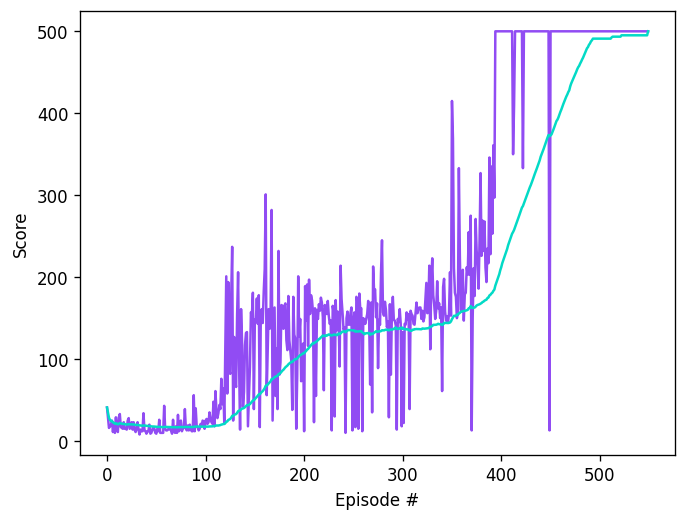

In [63]:
fig = plt.figure(dpi=120)
plt.plot(np.arange(len(scores)), scores, c="#6200ee", alpha=0.7)
plt.plot(scores_avg, c="#03dac6")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Visualize a smart agent

In [ ]:
load_path = f"{PATH_SAVE_DIR}/checkpoint.pth"
cuda = torch.cuda.is_available()

if cuda:
    checkpoint = torch.load(load_path)
else:
    checkpoint = torch.load(load_path, map_location=lambda storage, loc: storage)

env = gym.make("CartPole-v1", render_mode="human")
agent = DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=123)

agent.qnetwork.load_state_dict(checkpoint['state_dict'])

pygame.init()
window_size = (640, 640)
screen = pygame.display.set_mode(window_size)
running = True

for i in range(NUM_EPISODES_TEST):
    obs, _ = env.reset()
    for t in range(MAX_STEPS_EP):
        action = agent.act(obs)
        obs_next, reward, done, truncated, info = env.step(action)
        if done:
            break
            
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN and event.key == pygame.K_q:
                running = False
                
        if not running:
            break

    if not running:
        break

if not running:
    print("Shutting down...")
    env.close()
    pygame.quit()